In [2]:
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

import matplotlib.image as mpimg
import networkx as nx

In [5]:
# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(False)


0

In [6]:
robot_path = '/PioneerP3DX'
robot_handle = sim.getObject('/PioneerP3DX')

goal_handle = sim.getObject('/ReferenceFrame')

rmotor = sim.getObject(robot_path + '/rightMotor')
lmotor = sim.getObject(robot_path + '/leftMotor')

sensors = []
for i in range(16):
    sensors.append(sim.getObject(robot_path + f'/ultrasonicSensor[{i}]'))

In [114]:
# Start simulation
sim.startSimulation()

sim.setJointTargetVelocity(rmotor, 0)
sim.setJointTargetVelocity(lmotor, 0)

1

## Roadmaps
Implementação de roadmaps para **robô holonômico**.

(64, 64)

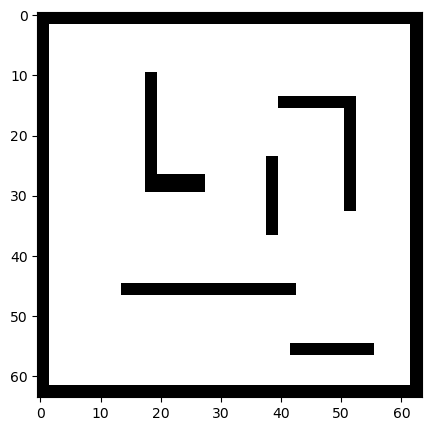

In [8]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

img = mpimg.imread('img/paredes-2.png') 
img = img.copy()

threshold = 0.5
img[img >= threshold] = 1
img[img < threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')
img.shape

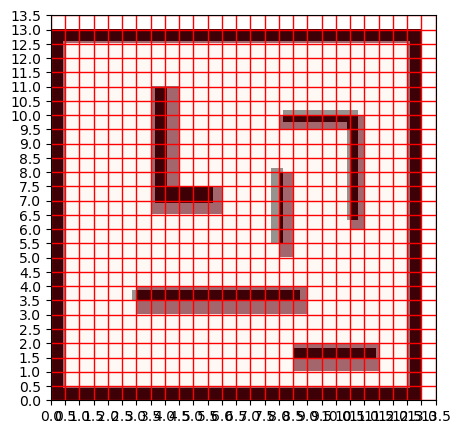

In [9]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([13, 13]) # Paredes 2

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 0.5

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid >= threshold] = 1
grid[grid < threshold] = 0        

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

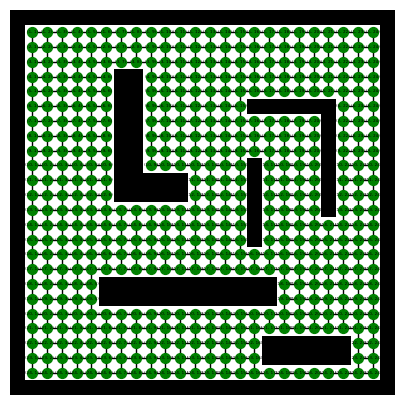

In [30]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

# first_node = list(G.nodes())[0]
# pos = {first_node: (first_node[1]*cell_size+cell_size/2, map_dims[0]-first_node[0]*cell_size-cell_size/2)}
# nx.draw_networkx_nodes(G, pos, nodelist=[first_node], node_size=50, node_color="g", ax=ax)

In [36]:
def plot_graph_position(node):
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))
    
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
    
    # Os vértices serão plotados no centro da célula  
    pos = {node: (node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2)}
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, node_color="g", ax=ax)

Note que no grafo **G**, o eixo x é representado pelo **segundo elemento** do nó. Ou seja, se cada nó possui a forma (i, j), essas coordenadas correspondem às coordenadas (y, x) na cena.

In [115]:
# Transformação das coordenadas na cena para as coordenadas no grafo
arr_x = lambda x: int((6.5 + x) * 2)
arr_y = lambda y: int((-y + 6.5) * 2)

# Transformação das coordenadas no grafo para as coordenadas na cena
scene_x = lambda x: (x / 2) - 6.5
scene_y = lambda y: -((y / 2) - 6.5)

In [136]:
*pgoal, _ = sim.getObjectPosition(goal_handle)
*pcurr, _ = sim.getObjectPosition(robot_handle)
print(pcurr)

[5.826098695380553, -4.082085735752692]


In [139]:
arra = (arr_y(pcurr[1]), arr_x(pcurr[0]))
scena = (scene_y(arra[1]), scene_x(arra[0]))
print(arra)
print(scena)

(21, 24)
(-5.5, 4.0)


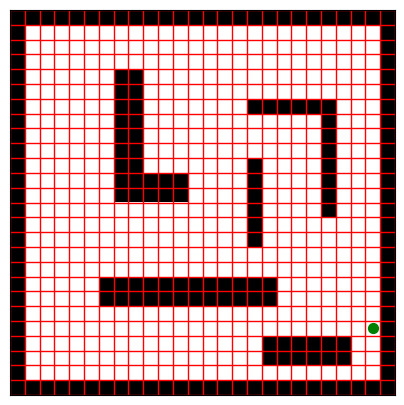

In [140]:
# Posição inicial do robô
start_node = (arr_y(pcurr[1]), arr_x(pcurr[0]))
plot_graph_position(start_node)

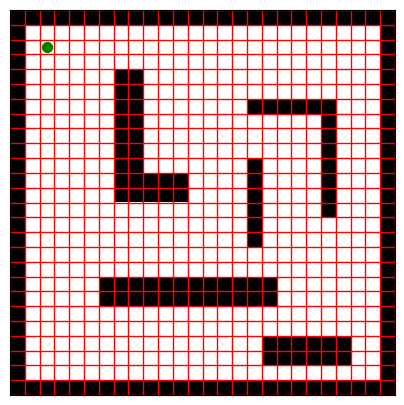

In [141]:
# Posição do alvo
end_node = (arr_y(pgoal[1]), arr_x(pgoal[0]))
plot_graph_position(end_node)

[(21, 24), (20, 24), (19, 24), (18, 24), (17, 24), (16, 24), (15, 24), (14, 24), (13, 24), (12, 24), (11, 24), (10, 24), (9, 24), (8, 24), (7, 24), (6, 24), (5, 24), (4, 24), (3, 24), (2, 24), (2, 23), (2, 22), (2, 21), (2, 20), (2, 19), (2, 18), (2, 17), (2, 16), (2, 15), (2, 14), (2, 13), (2, 12), (2, 11), (2, 10), (2, 9), (2, 8), (2, 7), (2, 6), (2, 5), (2, 4), (2, 3), (2, 2)]


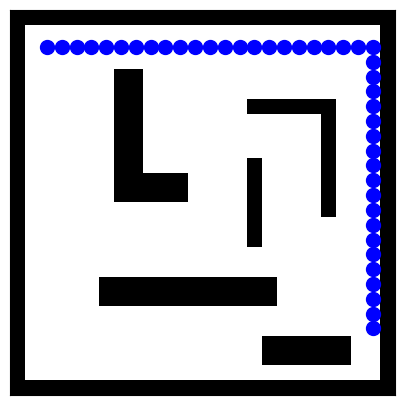

In [142]:
# Finalmente podemos determinar o menor caminho entre duas células

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
print(path)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

In [143]:
# Start simulation
sim.startSimulation()

sim.setJointTargetVelocity(rmotor, 0)
sim.setJointTargetVelocity(lmotor, 0)

kr = 0.5
kt = 0.7

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

for i in range(len(path)):
    goal_node = path[i]
    pgoal = np.array([scene_x(goal_node[1]), scene_y(goal_node[0])])
    
    rho = np.inf
    while rho > .5:
        *pcurr, _ = sim.getObjectPosition(robot_handle)
        _, _, ocurr = sim.getObjectOrientation(robot_handle)
        pcurr = np.array(pcurr[:2])
        
        dx, dy = pgoal - pcurr
        
        # Controlador [De Luca e Oriolo, 1994]
        v = kr*(dx*np.cos(ocurr) + dy*np.sin(ocurr))
        w = kt*(np.arctan2(dy, dx) - ocurr)
        
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)
        
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)
        sim.setJointTargetVelocity(rmotor, vr)
        sim.setJointTargetVelocity(lmotor, vl)

        # Apenas para quebrar o loop
        rho = np.sqrt(dx**2 + dy**2)

# End simulation
sim.setJointTargetVelocity(rmotor, 0)
sim.setJointTargetVelocity(lmotor, 0)

sim.stopSimulation()

[ 5.5 -4. ]
[ 5.5 -3.5]
[ 5.5 -3. ]
[ 5.5 -2.5]
[ 5.5 -2. ]
[ 5.5 -1.5]
[ 5.5 -1. ]
[ 5.5 -0.5]
[ 5.5 -0. ]
[5.5 0.5]
[5.5 1. ]
[5.5 1.5]
[5.5 2. ]
[5.5 2.5]
[5.5 3. ]
[5.5 3.5]
[5.5 4. ]
[5.5 4.5]
[5.5 5. ]
[5.5 5.5]
[5.  5.5]
[4.5 5.5]
[4.  5.5]
[3.5 5.5]
[3.  5.5]
[2.5 5.5]
[2.  5.5]
[1.5 5.5]
[1.  5.5]
[0.5 5.5]
[0.  5.5]
[-0.5  5.5]
[-1.   5.5]
[-1.5  5.5]
[-2.   5.5]
[-2.5  5.5]
[-3.   5.5]


KeyboardInterrupt: 

In [144]:
# End simulation
sim.stopSimulation()